## Analysis of the simpler Nuclear Shell model Hamiltonian

#### Imports

In [1]:
from collections import Counter
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState,QuadrupoleOperator,J2operator,write_j_square_twobody_file
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
import scipy
from typing import List,Type
from scipy.optimize import minimize,dual_annealing
from tqdm import trange
from src.qml_utils.utils import Schedule,SchedulerModel
from scipy.sparse import csr_matrix, diags
from numpy.linalg import eigh

/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


#### Hyperparameters of the model

In [ ]:
nlevels=3

tf=30
nsteps=100
number_of_parameters=10

file_name:str='data/usdb.nat'
qq_filename:str='data/qq.sd'
pairing_filename:str='data/pair_inter.sd'

j_square_filename:str=file_name+'_j2'
SPS=SingleParticleState(file_name=file_name)
energies:List=SPS.energies


nparticles_a:int=4
nparticles_b:int=0

size_a:int=SPS.energies.shape[0]//2
size_b:int=SPS.energies.shape[0]//2
title=r'$^{20}$O'

#### The target Hamiltonian

In [3]:
# Target Hamiltonian
TargetHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    TargetHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
TargetHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

TargetHamiltonian.get_hamiltonian()

egs,psis=TargetHamiltonian.get_spectrum(n_states=nlevels)
print('Hamiltonian shape=',TargetHamiltonian.hamiltonian.shape)
egs=egs[0]
print(egs)
psi0=psis[:,:1]

size= 24 12
Hamiltonian shape= (81, 81)
-23.93429270827921


#### What if we get an effective two-body matrix?

In [4]:
v_ab=np.zeros((energies.shape[0],energies.shape[0]))
v_dict={}
for a in trange(energies.shape[0]):
    for b in trange(energies.shape[0]):
        
        if a >= energies.shape[0]//2 and b <= energies.shape[0]//2:
            continue
        elif a <= energies.shape[0]//2 and b>= energies.shape[0]//2:
            continue
        else:
            for c in range(energies.shape[0]):
                for d in range(energies.shape[0]):
                    
                    if (a,c,b,d) in twobody_matrix.keys() or (a,c,d,b) in twobody_matrix.keys() or (c,a,b,d) in twobody_matrix.keys() or (c,a,d,b) in twobody_matrix.keys() :
                        v_ab[a,b]+=twobody_matrix[(a,c,b,d)]
                    else:
                        continue
            
        v_dict[(a,b)]=v_ab[a,b]/energies.shape[0]
        
v_ab=v_ab/energies.shape[0]

print(v_dict)
        

100%|██████████| 12/12 [00:00<00:00, 264.46it/s]

{(0, 0): -1.4633757998632582, (0, 1): -0.09660145721802471, (0, 2): -0.2832820833333332, (0, 3): 0.06594541666666665, (0, 4): -0.8068752567765719, (0, 5): -0.28061218430908946, (1, 0): -0.09660145721802464, (1, 1): -1.8647926277321973, (1, 2): -0.33333646540864853, (1, 3): -0.2832820833333333, (1, 4): 0.45199443871345474, (1, 5): -0.8069570678639003, (2, 0): -0.2832820833333332, (2, 1): -0.3333364654086484, (2, 2): -2.2662094556011367, (2, 3): -0.46308421574481295, (2, 4): -0.17658709687072457, (2, 5): 0.4519944387134546, (3, 0): 0.06594541666666665, (3, 1): -0.2832820833333333, (3, 2): -0.46308421574481295, (3, 3): -2.6676262834700757, (3, 4): 0.7206373320840932, (3, 5): 0.28495756054932747, (4, 0): -0.8068752567765722, (4, 1): 0.4519944387134547, (4, 2): -0.1765870968707246, (4, 3): 0.7206373320840931, (4, 4): -1.368869976764721, (4, 5): -0.43039629088752207, (5, 0): -0.2806121843090894, (5, 1): -0.8069570678639001, (5, 2): 0.45199443871345485, (5, 3): 0.2849575605493275, (5, 4): -0.

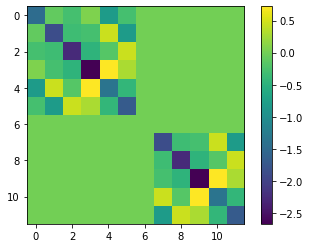

In [5]:
plt.imshow(v_ab)
plt.colorbar()
plt.show()

We define an Hamiltonian with this effective term

In [19]:
# Target Hamiltonian
EffectiveHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b)
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
    EffectiveHamiltonian.get_kinetic_operator(adj_matrix=v_dict)
else:
    EffectiveHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
print('size=',size_a+size_b,size_b)
EffectiveHamiltonian.get_external_potential(external_potential=energies[:size_a+size_b])

EffectiveHamiltonian.get_hamiltonian()

eigenvalues,eigenstates=np.linalg.eigh(EffectiveHamiltonian.hamiltonian.todense())

print(egs)



Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:02<00:00,  5.77it/s]


value= -1.4633757998632582 i,j= 0 0
value= -0.09660145721802471 i,j= 0 1
value= -0.2832820833333332 i,j= 0 2
value= 0.06594541666666665 i,j= 0 3
value= -0.8068752567765719 i,j= 0 4
value= -0.28061218430908946 i,j= 0 5
value= -0.09660145721802464 i,j= 1 0
value= -1.8647926277321973 i,j= 1 1
value= -0.33333646540864853 i,j= 1 2
value= -0.2832820833333333 i,j= 1 3
value= 0.45199443871345474 i,j= 1 4
value= -0.8069570678639003 i,j= 1 5
value= -0.2832820833333332 i,j= 2 0
value= -0.3333364654086484 i,j= 2 1
value= -2.2662094556011367 i,j= 2 2
value= -0.46308421574481295 i,j= 2 3
value= -0.17658709687072457 i,j= 2 4
value= 0.4519944387134546 i,j= 2 5
value= 0.06594541666666665 i,j= 3 0
value= -0.2832820833333333 i,j= 3 1
value= -0.46308421574481295 i,j= 3 2
value= -2.6676262834700757 i,j= 3 3
value= 0.7206373320840932 i,j= 3 4
value= 0.28495756054932747 i,j= 3 5
value= -0.8068752567765722 i,j= 4 0
value= 0.4519944387134547 i,j= 4 1
value= -0.1765870968707246 i,j= 4 2
value= 0.720637332084093

(225, 1)
(225, 225)
[-4.99880886 -4.82870643 -4.77817194 -4.60806951 -4.08087659 -4.01415862
 -3.86023967 -3.82518025 -3.79352169 -3.65507782 -3.53057189 -3.36046946
 -3.26632878 -3.09622635 -3.04569186 -2.95831491 -2.90724798 -2.87558943
 -2.84053001 -2.73767799 -2.63821402 -2.61263962 -2.5775802  -2.54592165
 -2.51618275 -2.46811159 -2.40747778 -2.35694328 -2.34608032 -2.27039229
 -2.18684085 -2.1437671  -2.09270017 -2.04975536 -1.97366467 -1.92313018
 -1.92259774 -1.79809181 -1.78468631 -1.75302775 -1.72028175 -1.68522234
 -1.65964794 -1.65356378 -1.62798938 -1.59825048 -1.59292996 -1.56319107
 -1.53153251 -1.51511991 -1.49007794 -1.46458542 -1.45584448 -1.43901101
 -1.39308864 -1.37229304 -1.34255415 -1.29448299 -1.28574205 -1.23520755
 -1.22583483 -1.17245172 -1.09676368 -1.06510512 -1.00519791 -0.97013849
 -0.90573394 -0.84510012 -0.80215532 -0.80003606 -0.78370267 -0.76729007
 -0.73563151 -0.7005721  -0.67553013 -0.67499769 -0.6452588  -0.6244632
 -0.61360024 -0.59772008 -0.5785

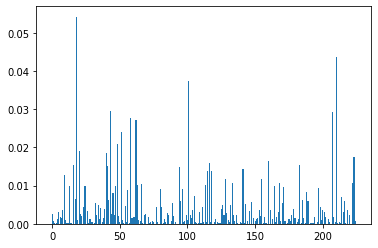

In [20]:
print(psi0.shape)
print(eigenstates.shape)

overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.show()

#### Define the simpler Hamiltonian

Hyperparameters

In [4]:
pairing_coupling=+2
quadrupole_coupling=+2

In [5]:
matrix_qq,_=get_twobody_nuclearshell_model(file_name=qq_filename)



QQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
QQoperator.get_twobody_interaction(twobody_dict=matrix_qq)
QQoperator.get_hamiltonian()


#effective QQ operator
local_qq_matrix={}
for key,value in matrix_qq.items():
    a,b,c,d=key
    
    n,l,ja,m,t,tz_a=SPS.state_encoding[a]
    n,l,jb,m,t,tz_b=SPS.state_encoding[b]
    n,l,jc,m,t,tz_c=SPS.state_encoding[c]
    n,l,jd,m,t,tz_d=SPS.state_encoding[d]
    if ja==jb and jb==jc and jc==jd:
        local_qq_matrix[(a,b,c,d)]=value


LocalQQoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
LocalQQoperator.get_twobody_interaction(twobody_dict=local_qq_matrix)
LocalQQoperator.get_hamiltonian()

matrix_pairing,_=get_twobody_nuclearshell_model(file_name=pairing_filename)
PPoperator=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
PPoperator.get_twobody_interaction(twobody_dict=matrix_pairing)
PPoperator.get_hamiltonian()
mean_field_hamiltonian=diags(TargetHamiltonian.hamiltonian.diagonal(), format='csr')


simpler_target_hamiltonian=(mean_field_hamiltonian+pairing_coupling*PPoperator.hamiltonian+quadrupole_coupling*QQoperator.hamiltonian)

eigenvalues,eigenstates=eigh(simpler_target_hamiltonian.todense())

print('egs simpler=',eigenvalues[0],'eigenstates=',eigenstates.shape)




Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:59<00:00,  2.47s/it]
9588it [00:11, 799.99it/s] 
1048it [00:01, 847.15it/s]


Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:24<00:00,  1.01s/it]
864it [00:01, 741.12it/s]


egs simpler= -46.676943432106654 eigenstates= (81, 81)


#### Analysis of the overlap with respect to the eigenstates of the Simpler NSM

[-46.67694343 -29.68580246 -24.63915873 -24.43290612 -23.67247716
 -22.87362988 -22.56177727 -21.96657808 -21.34530639 -20.16328554
 -19.2839782  -19.28244764 -18.70166936 -18.11949622 -14.16213904
 -12.88353373 -12.67947544 -12.42509485 -11.93121216 -11.41465689
 -11.20065125 -10.96127187 -10.56847443  -9.78658138  -9.77546772
  -8.06595595  -7.93486635  -7.32189331  -7.24015141  -6.92381692
  -6.77562483  -6.67400105  -6.63245765  -6.32233573  -6.27385547
  -6.0816418   -5.85889588  -5.58958201  -5.26621151  -5.07369181
  -4.78003764  -4.07407775  -3.73819529  -3.59690613  -2.70391466
  -2.55289041  -2.34566907  -1.99598072  -1.92500397  -1.8165241
  -1.52072449  -0.92692318  -0.63886188   0.41312504   0.45760219
   0.57420702   0.81272758   1.23186119   1.2912245    1.60223583
   1.6956525    1.81168122   1.92903703   2.18698132   2.38220914
   2.81957114   4.22268165   4.519977     5.63484861   6.16644089
   6.38727284   6.79369652   7.25863781   7.36592628   7.4649542
   8.6495240

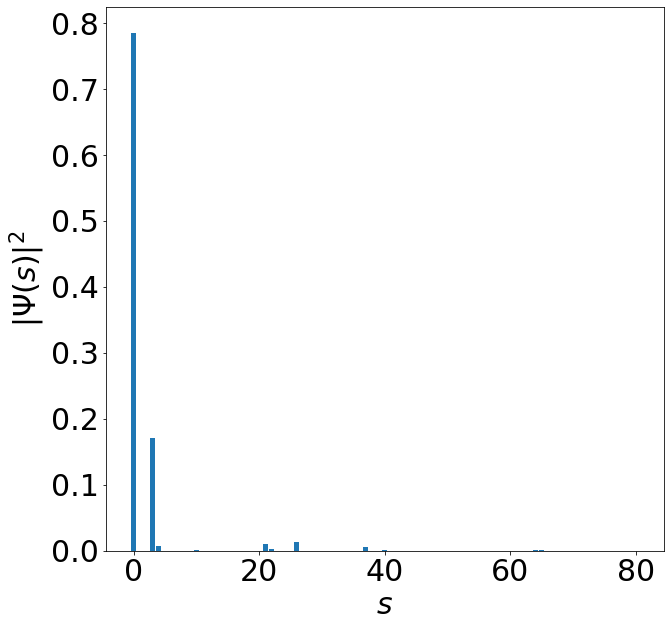

In [6]:
overlap=np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',psi0[:,0].conjugate(),eigenstates))
print(eigenvalues)
plt.figure(figsize=(10,10))
plt.bar(np.arange(overlap.shape[0]),overlap)
plt.xlabel(r'$s$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.show()

#### Quantum Optimal Control with the simpler Hamiltonian

Initialize the initial Hamiltonian

In [7]:
#### Initial Hamiltonian
min_b=np.zeros(size_a+size_b)

if file_name=='data/cki':
    order_of_filling=np.asarray([0,3,1,2,4,5])
    order_of_filling_protons=order_of_filling+size_a
else:
    order_of_filling=np.asarray([0,5,1,4,2,3,6,7,8,11,9,10])
    order_of_filling_protons=order_of_filling+size_a


min_b[order_of_filling[:nparticles_a]]=1
min_b[order_of_filling_protons[:nparticles_b]]=1




print('initial state=',min_b)
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
kinetic_term:Dict={}
adj_matrix=np.zeros((size_a+size_b,size_a+size_b))
idx=InitialHamiltonian._get_index(element=min_b)
print('idx=',idx)
psi_configuration=np.zeros(TargetHamiltonian.hamiltonian.shape[0])
psi_configuration[idx]=1
min=psi_configuration.transpose().dot(TargetHamiltonian.hamiltonian.dot(psi_configuration))      
external_field=np.zeros(size_a+size_b)
external_field=-1*(np.abs(min)/(nparticles_a+nparticles_b))*min_b
print('min energy=',min)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()


initial state= [1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
idx= 0
min energy= -20.1382


In [10]:
model=SchedulerModel(initial_state=psi_configuration,target_hamiltonian=PPoperator.hamiltonian,second_target_hamiltonian=QQoperator.hamiltonian,initial_hamiltonian=InitialHamiltonian.hamiltonian,mean_field_target_hamiltonain=mean_field_hamiltonian,tf=tf,nsteps=nsteps,number_of_parameters=number_of_parameters,type='F-CRAB',seed=42,reference_hamiltonian=TargetHamiltonian.hamiltonian,mode='annealing ansatz',random=True)
print(model.parameters.shape)


bounds=[(0,20) for i in range(model.parameters.shape[0])]

local_search_options = {
    'method': 'L-BFGS-B',  # Specify L-BFGS-B as the local search method
    'bounds': bounds       # Pass the bounds
}

res = minimize(
                    model.forward,
                    model.parameters,
                    method='L-BFGS-B',
                    tol=10**-6,
                    callback=model.callback,
                    options=None,
                    
)

#res=dual_annealing(model.forward,bounds,callback=model.callback,maxiter=1000,maxfun=1000,local_search_options=local_search_options,no_local_search=True)

model.parameters = res.x
energy = model.forward(model.parameters)
print(energy,egs)
print(model.parameters)

(60,)
(-21.569141305495478-8.881784197001252e-16j)
(-22.093468766412357+1.7763568394002505e-15j)
(-22.76909378042285+0j)
(-23.03960571667303+0j)
(-23.287572319331886+0j)
(-23.445578986145136+1.3322676295501878e-15j)
(-23.517590283797844+8.881784197001252e-16j)
(-23.551274374322634-1.1102230246251565e-16j)
(-23.576285289233347+0j)
(-23.59852738164048-8.881784197001252e-16j)
(-23.62058241041052+1.7763568394002505e-15j)
(-23.630589339390703+1.7763568394002505e-15j)
(-23.63848536380695-8.881784197001252e-16j)


KeyboardInterrupt: 

#### Analysis of the Optimization

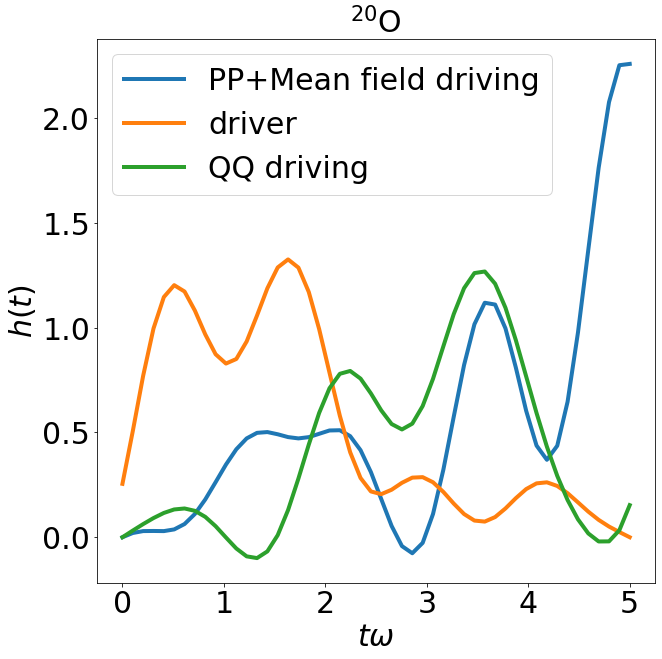

(81, 1)
(0.05470948664442811+0j)


/opt/anaconda3/envs/dft_env/lib/python3.9/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


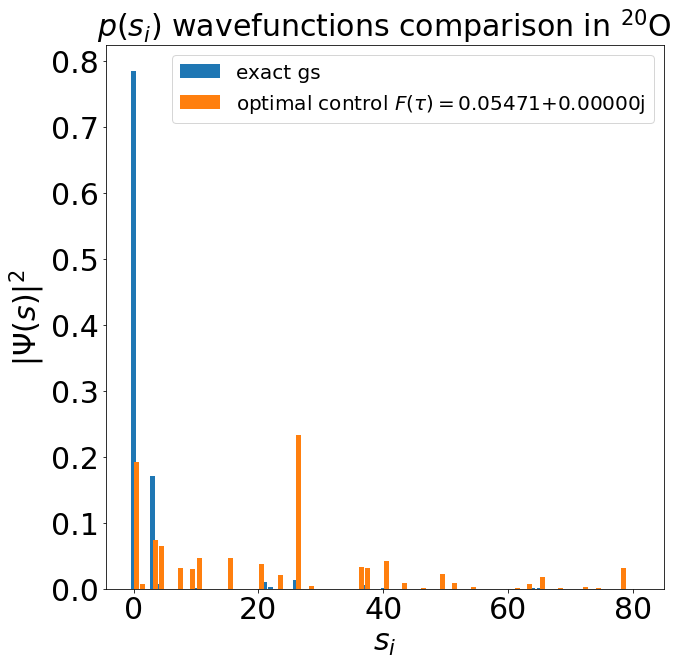

In [36]:
hd,ht,ht2=model.get_driving()
plt.figure(figsize=(10,10))
plt.title(title,fontsize=30)

plt.plot(model.time,ht,label='PP+Mean field driving',linewidth=4)
plt.plot(model.time,hd,label='driver',linewidth=4)
plt.plot(model.time,ht2,label='QQ driving',linewidth=4)
plt.xlabel(r'$t\omega$',fontsize=30)
plt.ylabel(r'$h(t)$',fontsize=30)
plt.legend(fontsize=30)
plt.tick_params(labelsize=30)
plt.show()


overlap_optimization=np.einsum('i,ia->a',model.psi.conjugate(),eigenstates)*np.conjugate(np.einsum('i,ia->a',model.psi.conjugate(),eigenstates))
print(psi0.shape)
print((psi0[:,0].conjugate().dot(model.psi))*np.conjugate((psi0[:,0].conjugate().dot(model.psi))))
plt.figure(figsize=(10,10))
plt.title(r'$p(s_i)$ wavefunctions comparison in '+title,fontsize=30)
plt.bar(np.arange(overlap.shape[0]),overlap,label='exact gs')
plt.bar(np.arange(overlap.shape[0])+0.5,overlap_optimization,label=r'optimal control $F(\tau)=$'+f'{(psi0[:,0].conjugate().dot(model.psi))*np.conjugate((psi0[:,0].conjugate().dot(model.psi))):.5f}')
plt.xlabel(r'$s_i$',fontsize=30)
plt.ylabel(r'$|\Psi(s)|^2$',fontsize=30)
plt.tick_params(labelsize=30)
plt.legend(fontsize=20)
plt.show()


#### Analysis of the results

In [ ]:
hamiltonian_interpolate=(1-model.time/model.tf)